# Load the data

In [1]:
from src.colors import bcolors
from config import Config

c = bcolors()
config = Config()

CKPT_PATH = 'checkpoints/resnet/'

In [2]:
from sklearn.preprocessing import OneHotEncoder
from torchvision import transforms
from torch import nn
import pandas as pd
import kornia.augmentation as K
import torch
from src.pickle_loader import load_object, save_object

stats = load_object("data/eurosat_ms_mean_std")
mean = stats['mean']
std = stats['std']
chan_idx = stats['idx']

CHANNELS = [12, 11, 10, 8, 7, 6, 5, 4, 3, 2, 1, 0]
# CHANNELS = [3, 2, 1]
NUM_CLASSES = 10
NUM_AUG = 1

df = pd.read_csv(config.TRAIN_FILE)

encoder = OneHotEncoder()
encoder = encoder.fit(df[['label']].values.reshape(-1, 1))
save_object(encoder, "data/on_hot_encoder")

In [3]:
from sklearn.model_selection import train_test_split
from src.datasets.EuroSatMS import EuroSatMS


train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['label'])

test_df, val_df = train_test_split(val_df, test_size=0.7)

ds_train = EuroSatMS(
    train_df, 
    config.TRAIN_MS_DIR,
    encoder=encoder,
    num_aug=NUM_AUG, 
    select_chan=CHANNELS
)

ds_val = EuroSatMS(
    val_df, 
    config.TRAIN_MS_DIR,
    encoder=encoder,
    num_aug=NUM_AUG, 
    select_chan=CHANNELS
)

ds_test = EuroSatMS(
    test_df, 
    config.TRAIN_MS_DIR,
    encoder=encoder,
    num_aug=NUM_AUG, 
    select_chan=CHANNELS
)

print(f"""\n{c.OKCYAN}Train dataset: {len(ds_train)} samples{c.ENDC}""")
print(f"""{c.OKCYAN}Validation dataset: {len(ds_val)} samples{c.ENDC}""")
print(f"""{c.OKCYAN}Test dataset:       {len(ds_test)} samples{c.ENDC}""")


Preloading images...

Images:         21600
Augmentations:  21600
Jobs:           -4 

Time taken:      4 min 8.9861581325531 sec 

Preloading images...

Images:         3780
Augmentations:  3780
Jobs:           -4 

Time taken:      0 min 5.600597620010376 sec 

Preloading images...

Images:         1620
Augmentations:  1620
Jobs:           -4 

Time taken:      0 min 2.765972852706909 sec 

Train dataset: 21600 samples
Validation dataset: 3780 samples


In [8]:
transform_mean_std = transforms.Compose([
    K.Normalize(mean=mean[CHANNELS], std=std[CHANNELS])
])

transform_pt = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

augmentation = nn.Sequential(
    K.RandomHorizontalFlip(p=0.6),
    K.RandomVerticalFlip(p=0.6),
    K.RandomAffine(degrees=45, translate=None, scale=None, shear=None, resample="nearest", padding_mode=2, p=0.6),
    K.RandomShear(shear=0.3, resample="nearest", padding_mode=2, p=0.6),
    # K.RandomContrast(contrast=(0.8, 1.2), p=0.6),
    K.RandomBoxBlur(kernel_size=(3, 3), p=0.6),
    K.RandomBrightness(brightness=(0.8, 1.2), p=0.6),
    K.CenterCrop(size=(64, 64))
)

ds_train.augment = augmentation
ds_val.augment = None
ds_test.augment = None

ds_train.transform = None
ds_val.transform = None
ds_test.transform = None

In [9]:
from src.training.data import EuroSatDataModule

print(ds_val[0][0].shape)

BATCH_SIZE = 64

data_module = EuroSatDataModule(ds_train, ds_val, ds_test, BATCH_SIZE)
print(f"""{c.OKGREEN}Initialized the data module...{c.ENDC}""")

torch.Size([12, 64, 64])
Initialized the data module...


# CNN Model Training

In [13]:
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import BackboneFinetuning, ModelCheckpoint
from src.training.cnn import LitEuroSatCnn
from datetime import datetime


lightning_model = LitEuroSatCnn(
    num_classes=NUM_CLASSES,
    learning_rate=0.01, 
    num_channels=len(CHANNELS), 
    kernel_size=[3, 3],
    momentum=0.9,
    gamma=0.9
)

logger = WandbLogger(
    project="eurosat_cnn",
    name="cnn_v1",
    log_model=False,
)

checkpoint_callback = ModelCheckpoint(
    dirpath=CKPT_PATH + datetime.now().strftime("%H-%M"),
    filename='cnn_c12_k33-{epoch:02d}-{val_accuracy:.2f}',
    save_top_k=1, 
    monitor="val_loss",
    verbose=False
)

trainer = Trainer(
    max_epochs=20,
    accelerator="gpu", 
    devices=1,
    logger=logger,
    callbacks=[checkpoint_callback],
)

trainer.fit(lightning_model, datamodule=data_module)

/home/tobias/Schreibtisch/Uni/HSG/ML/EuroSatClassification/.venv/lib/python3.8/site-packages/pytorch_lightning/loggers/wandb.py:395: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | model     | EuroSatCNN       | 19.5 M
1 | criterion | CrossEntropyLoss | 0     
-----------------------------------------------
19.5 M    Trainable params
0         Non-trainable params
19.5 M    Total params
77.971    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.


In [14]:
trainer.test(lightning_model, datamodule=data_module)

MisconfigurationException: No `test_step()` method defined to run `Trainer.test`.

# Pretrained Model Training
### Training Phase 1
##### Pretrained ResNet50, ResNet18, AlexNet Model

In [11]:
import torchgeo.models as models
from torchgeo.models import ResNet18_Weights, ResNet50_Weights


def get_pretrained_model(model_name):
    if model_name == "B13_rn50_moco_0099":
        m = models.resnet50(weights=None)
        m.fc = nn.Linear(2048,19)
        m.conv1 = nn.Conv2d(
            13, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
        )
        ckp = torch.load("B13_rn50_moco_0099.pth", map_location="cpu")
        sd = ckp['state_dict']
        
        for key in list(sd.keys()):
            if key.startswith('module.encoder_q') and not key.startswith('module.encoder_q.fc'):
                sd[key[len("module.encoder_q."):]] = sd[key]
            del sd[key]
        
        msg = m.load_state_dict(sd, strict=False)
        assert set(msg.missing_keys) == {"fc.weight", "fc.bias"}
        
        return m
    elif "resnet18_RGB_MOCO" in model_name:
        return models.resnet18(weights=ResNet18_Weights.SENTINEL2_RGB_MOCO)
    elif "resnet50_RGB_MOCO" in model_name:
        return models.resnet50(weights=ResNet50_Weights.SENTINEL2_RGB_MOCO)

m_name = "resnet18_RGB_MOCO"

In [12]:
from datetime import datetime
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import BackboneFinetuning, ModelCheckpoint
from pytorch_lightning import Trainer
from src.training.pretrainedModels import EuroSatPreTrainedModel

model = get_pretrained_model(m_name)

model_train = EuroSatPreTrainedModel(
    backbone=model,
    learning_rate=0.03,
    gamma=0.95,
    momentum=0.9,
    dropout=0.2,
    weight_decay=1e-4
)

logger = WandbLogger(
    project="eurosat_resnet",
    name="resnet_pretrained_v1",
    log_model=False,
)

checkpoint_callback = ModelCheckpoint(
    dirpath=CKPT_PATH + datetime.now().strftime("%H-%M"),
    save_top_k=1, 
    monitor="val_loss",
    verbose=False
)

trainer = Trainer(
    max_epochs=10,
    accelerator="gpu", 
    devices=1,
    logger=logger,
    callbacks=[checkpoint_callback],
)

trainer.fit(model_train, datamodule=data_module)

/home/tobias/Schreibtisch/Uni/HSG/ML/EuroSatClassification/.venv/lib/python3.8/site-packages/pytorch_lightning/loggers/wandb.py:395: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type             | Params
------------------------------------------------
0 | backbone   | ResNet           | 11.2 M
1 | classifier | Sequential       | 5.1 K 
2 | criterion  | CrossEntropyLoss | 0     
------------------------------------------------
5.1 K     Trainable params
11.2 M    Non-trainable params
11.2 M    Total params
44.727    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

RuntimeError: Given groups=1, weight of size [64, 3, 7, 7], expected input[64, 12, 64, 64] to have 3 channels, but got 12 channels instead

In [7]:
trainer.test(model_train, datamodule=data_module, ckpt_path=checkpoint_callback.best_model_path)


KeyboardInterrupt



In [ ]:
model = get_pretrained_model(m_name)

model_train = EuroSatPreTrainedModel.load_from_checkpoint(
    "checkpoints/resnet/22-39/epoch=8-step=765.ckpt",
    backbone=model,
    freeze_backbone=False,
    learning_rate=0.00001,
    gamma=0.9,
    momentum=0.9,
    dropout=0.3,
    weight_decay=0.000001
)

logger = WandbLogger(
    project="eurosat_resnet",
    name="resnet_pretrained_v1",
    log_model=False,
)

checkpoint_callback = ModelCheckpoint(
    dirpath=CKPT_PATH + datetime.now().strftime("%H-%M"),
    save_top_k=1, 
    monitor="val_loss",
    verbose=False
)

trainer = Trainer(
    max_epochs=5,
    accelerator="gpu", 
    devices=1,
    logger=logger,
    callbacks=[checkpoint_callback],
)

trainer.fit(model_train, datamodule=data_module)

In [ ]:
trainer.validate(model_train, datamodule=data_module)

# Predict on the test set

In [43]:
from torch import nn
from src.datasets.EuroSatTest import EuroSatTestSet
from torch.utils.data import DataLoader
from config import Config

config = Config()

CHANNELS = [11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1, 0]
# CHANNELS = [3, 2, 1]

dataset = EuroSatTestSet(config.TEST_MS_DIR, select_chan=CHANNELS, add_b10=False, augment=augmentation)
dataloader = DataLoader(dataset, batch_size=64, shuffle=False)



Preloading images...
Number of images: 4232
Number of jobs:   -4 

Time taken:      0 min 11.056482076644897 sec 


In [44]:
from src.training.pretrainedModels import EuroSatPreTrainedModel
from src.training.cnn import LitEuroSatCnn
from config import Config

config = Config()

model_eval = LitEuroSatCnn.load_from_checkpoint(
    "checkpoints/cnn_c12_k33_85acu.ckpt",
    num_classes=NUM_CLASSES,
    learning_rate=0.025, 
    num_channels=len(CHANNELS), 
    kernel_size=[3, 3],
    momentum=0.9,
    gamma=0.9
)


# model = get_pretrained_model(m_name)
# model_eval = EuroSatPreTrainedModel.load_from_checkpoint(
#     "checkpoints/resnet/22-39/epoch=8-step=765.ckpt",
#     backbone=model,
#     learning_rate=1e-4,
#     momentum=0.9,
#     dropout=0,
#     weight_decay=0.0001
# )

# Set the model to evaluation mode
model_eval.eval()

LitEuroSatCnn(
  (model): EuroSatCNN(
    (conv_layer): Sequential(
      (0): Conv2d(12, 32, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
      (4): ReLU()
      (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (fc_layer): Sequential(
      (0): Flatten(start_dim=1, end_dim=-1)
      (1): Linear(in_features=18496, out_features=1024, bias=True)
      (2): ReLU()
      (3): Linear(in_features=1024, out_features=512, bias=True)
      (4): ReLU()
      (5): Linear(in_features=512, out_features=10, bias=True)
    )
  )
  (criterion): CrossEntropyLoss()
)

In [45]:
import torch
import numpy as np


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_eval = model_eval.to(device)
model_eval.eval()

N_CLASSES = 10
categorys = encoder.categories_[0]
print(categorys)

predictions = []
probabilities = []
ohe = []
images = []
sample_ids = []

with torch.no_grad():
    for batch in dataloader:
        inputs, samp_id = batch
        inputs = inputs.to(device)

        outputs = model_eval(inputs)

        probs = torch.softmax(outputs, dim=1).cpu()
        
        _, preds = torch.max(probs, 1)
        preds = preds.cpu().numpy()
        
        preds_enc = np.zeros((preds.size, N_CLASSES))
        preds_enc[np.arange(preds.size), preds] = 1
        
        pred_labels = np.array([categorys[p] for p in preds])
        # true_labels = np.array([categorys[np.argmax(p)] for p in samp_id.cpu().numpy()])
        
        predictions.extend(pred_labels)
        images.extend(inputs.cpu())
        sample_ids.extend(samp_id.cpu())
        probabilities.extend(probs.cpu())
        # true_l.extend(true_labels)
        ohe.extend(preds_enc)


['AnnualCrop' 'Forest' 'HerbaceousVegetation' 'Highway' 'Industrial'
 'Pasture' 'PermanentCrop' 'Residential' 'River' 'SeaLake']


In [46]:
import pandas as pd


sub_df = pd.DataFrame({'test_id': np.array(sample_ids), 'label': np.array(predictions)})
sub_df = sub_df.sort_values(by='test_id')
print(sub_df.head())
print(np.array(sample_ids))

sub_df.to_csv('submission.csv', index=False)
print(np.unique(predictions, return_counts=True))

      test_id                 label
1218        0  HerbaceousVegetation
1454        1  HerbaceousVegetation
29          2  HerbaceousVegetation
2598        3               SeaLake
2512        4  HerbaceousVegetation
[2469 1969 1875 ... 2857 3603   56]
(array(['HerbaceousVegetation', 'Highway', 'Industrial', 'Residential',
       'River', 'SeaLake'], dtype='<U20'), array([3054,    1,   30,   23,  113, 1011]))


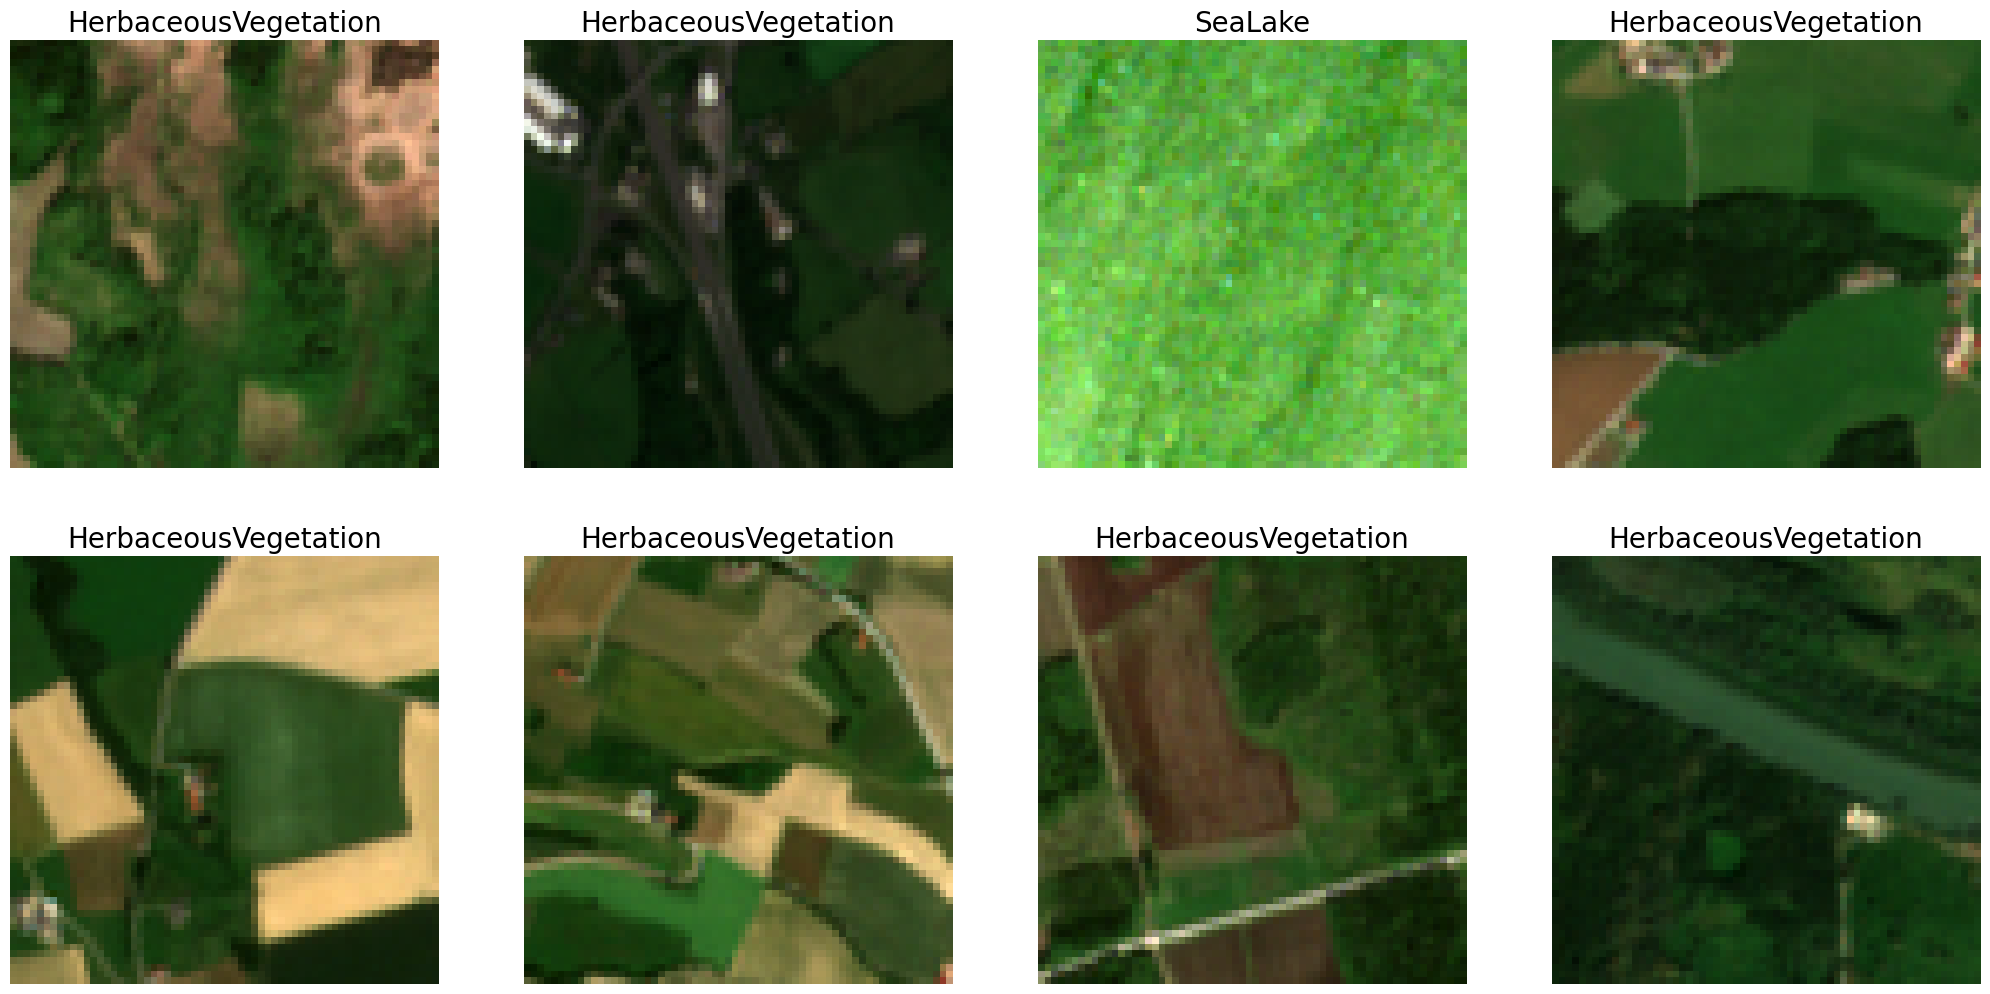

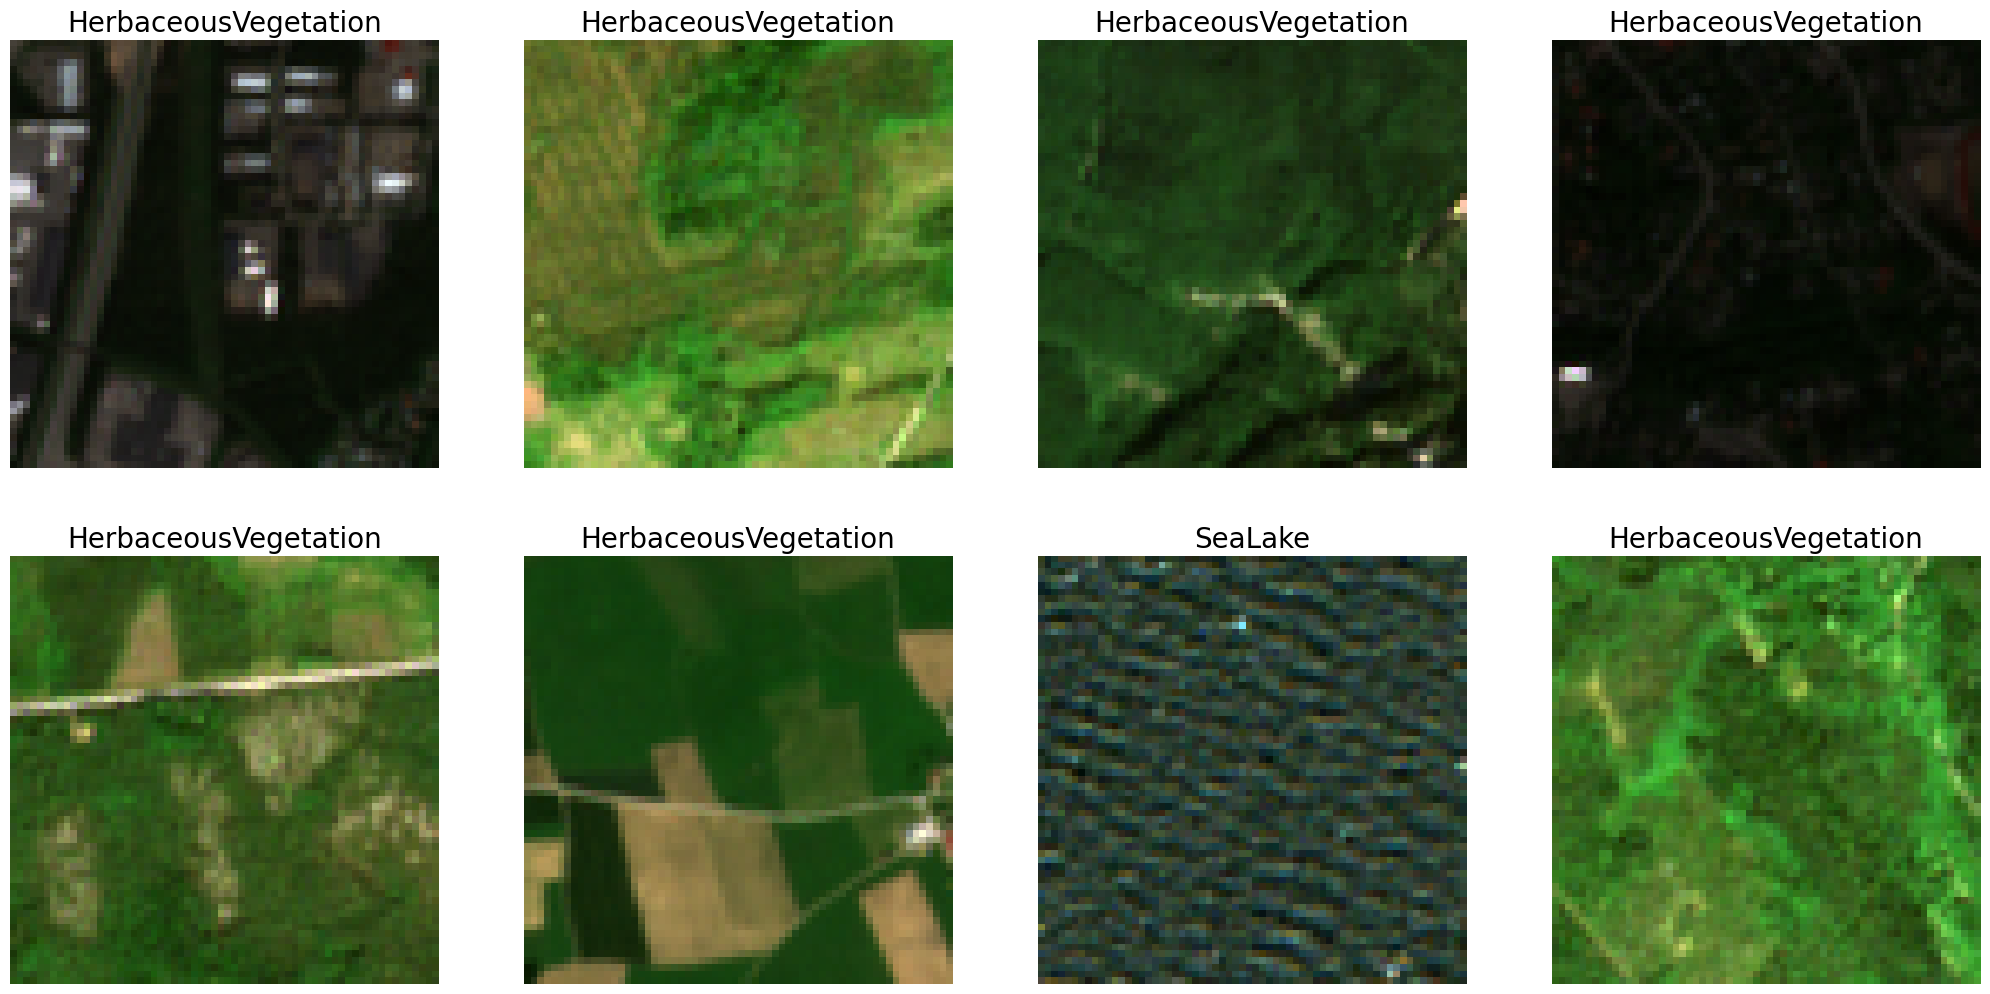

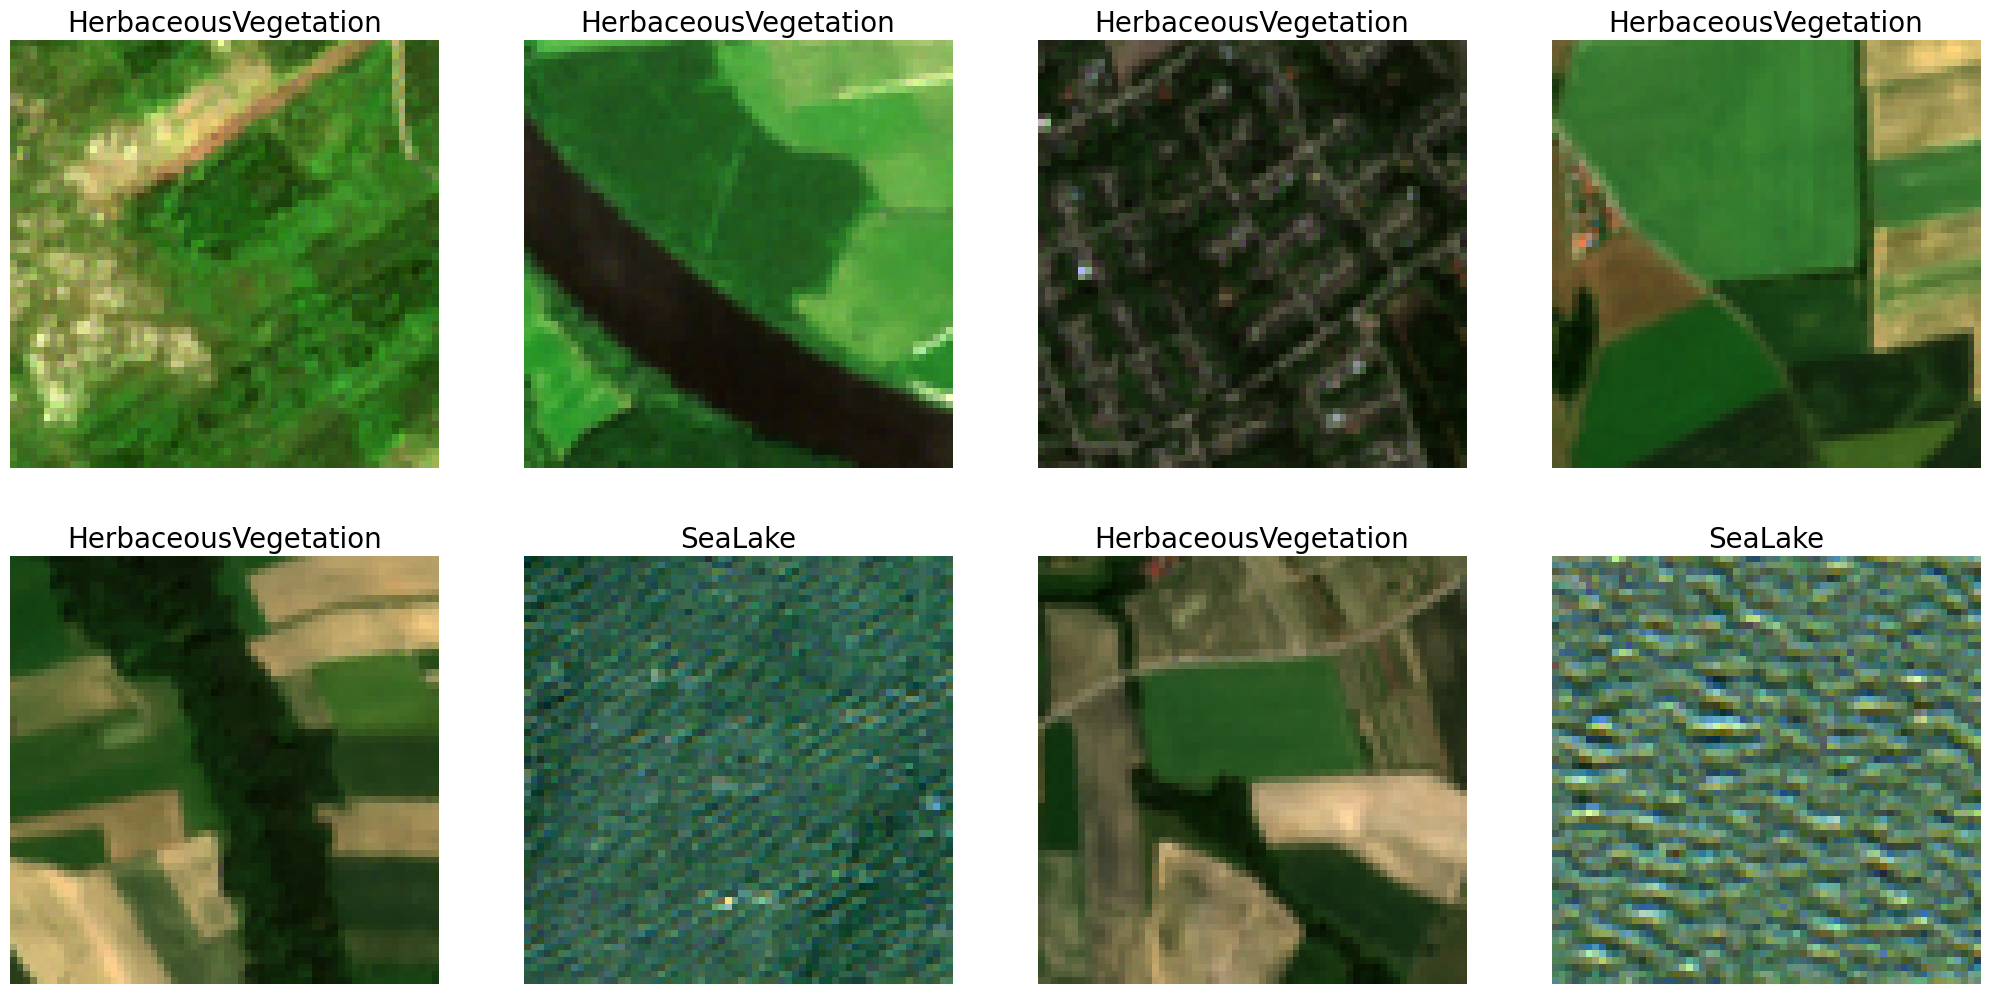

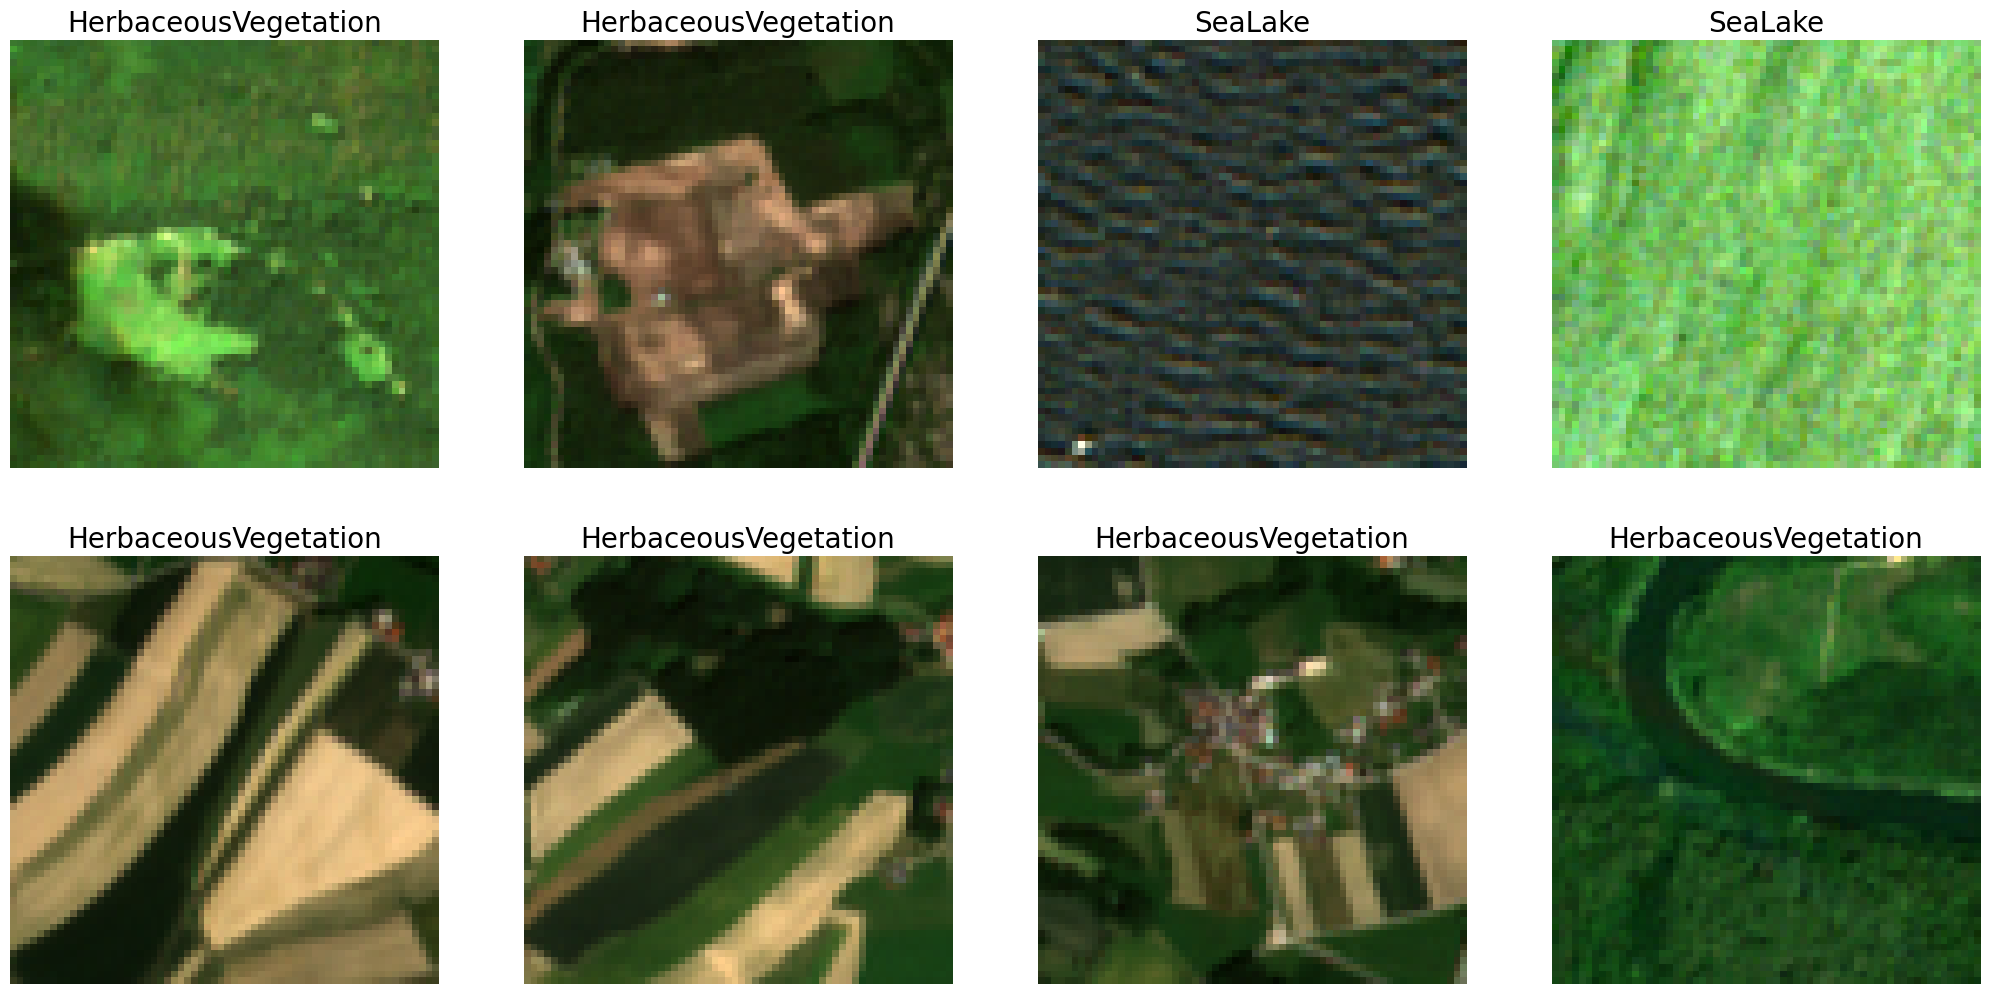

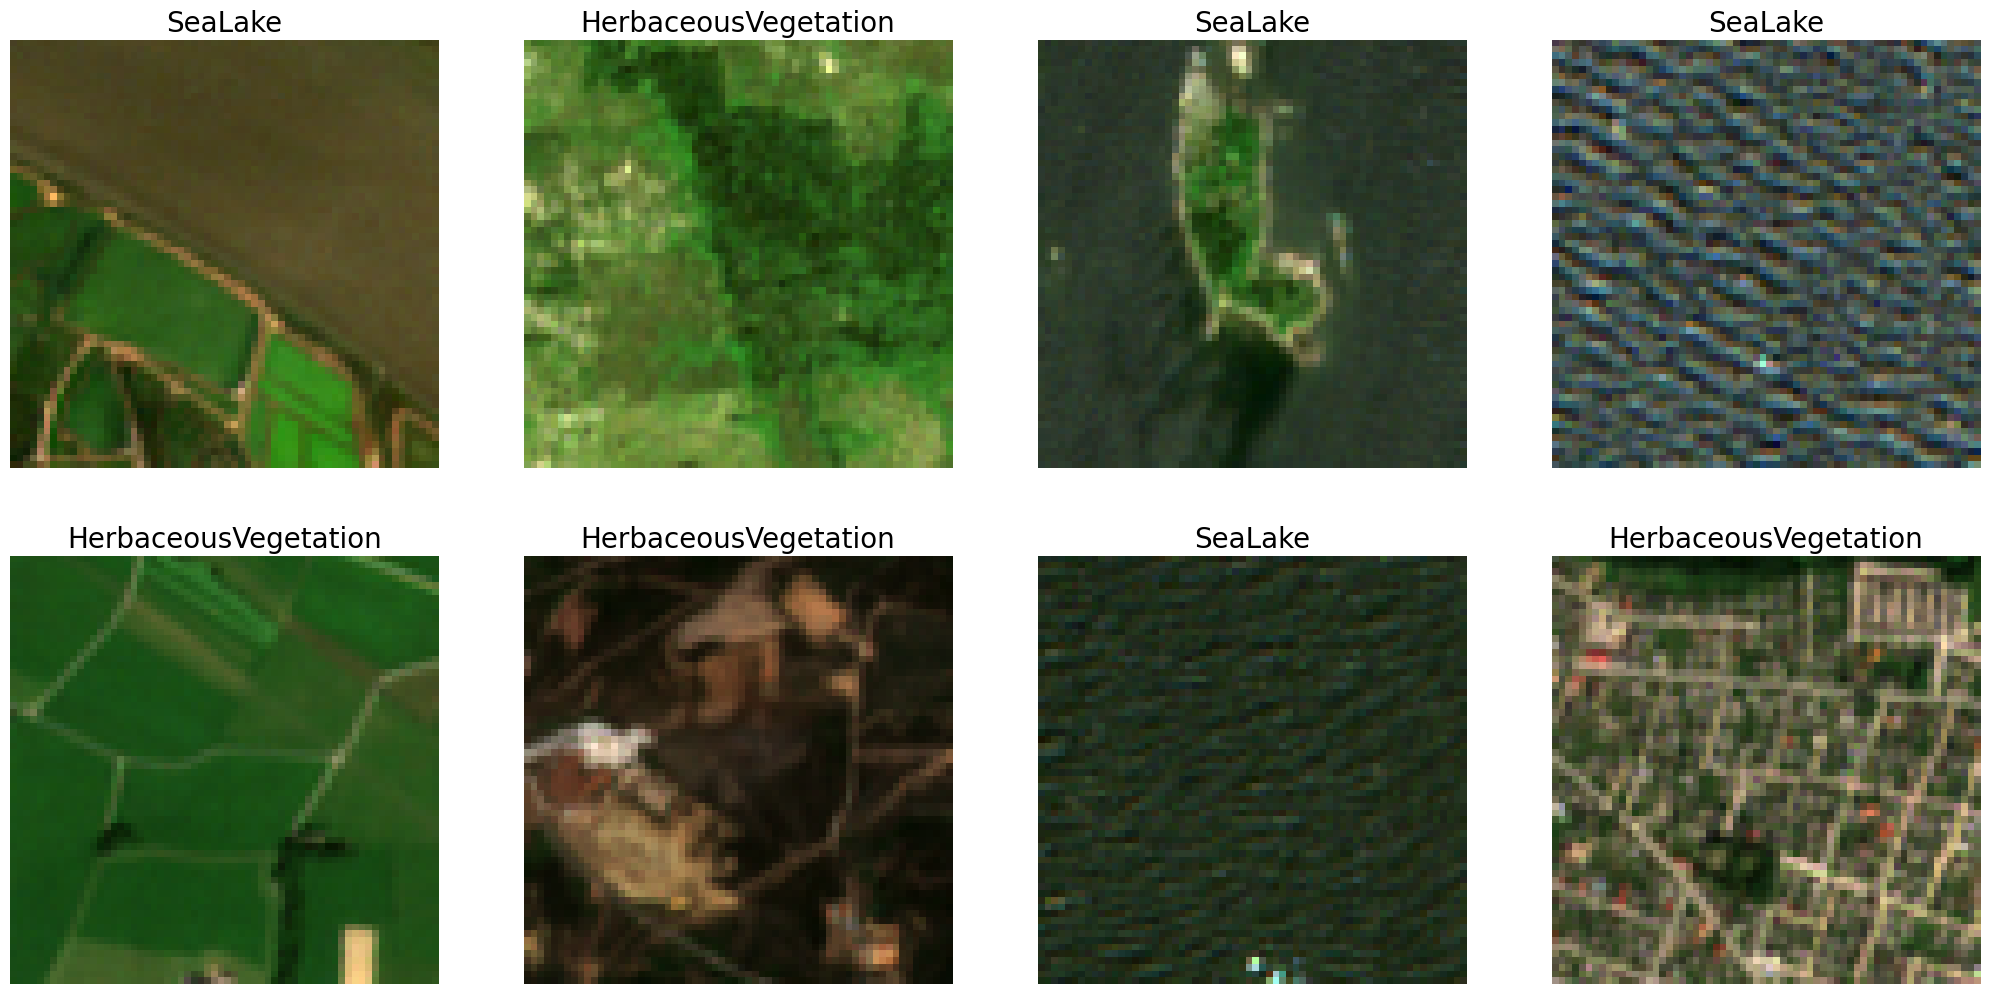

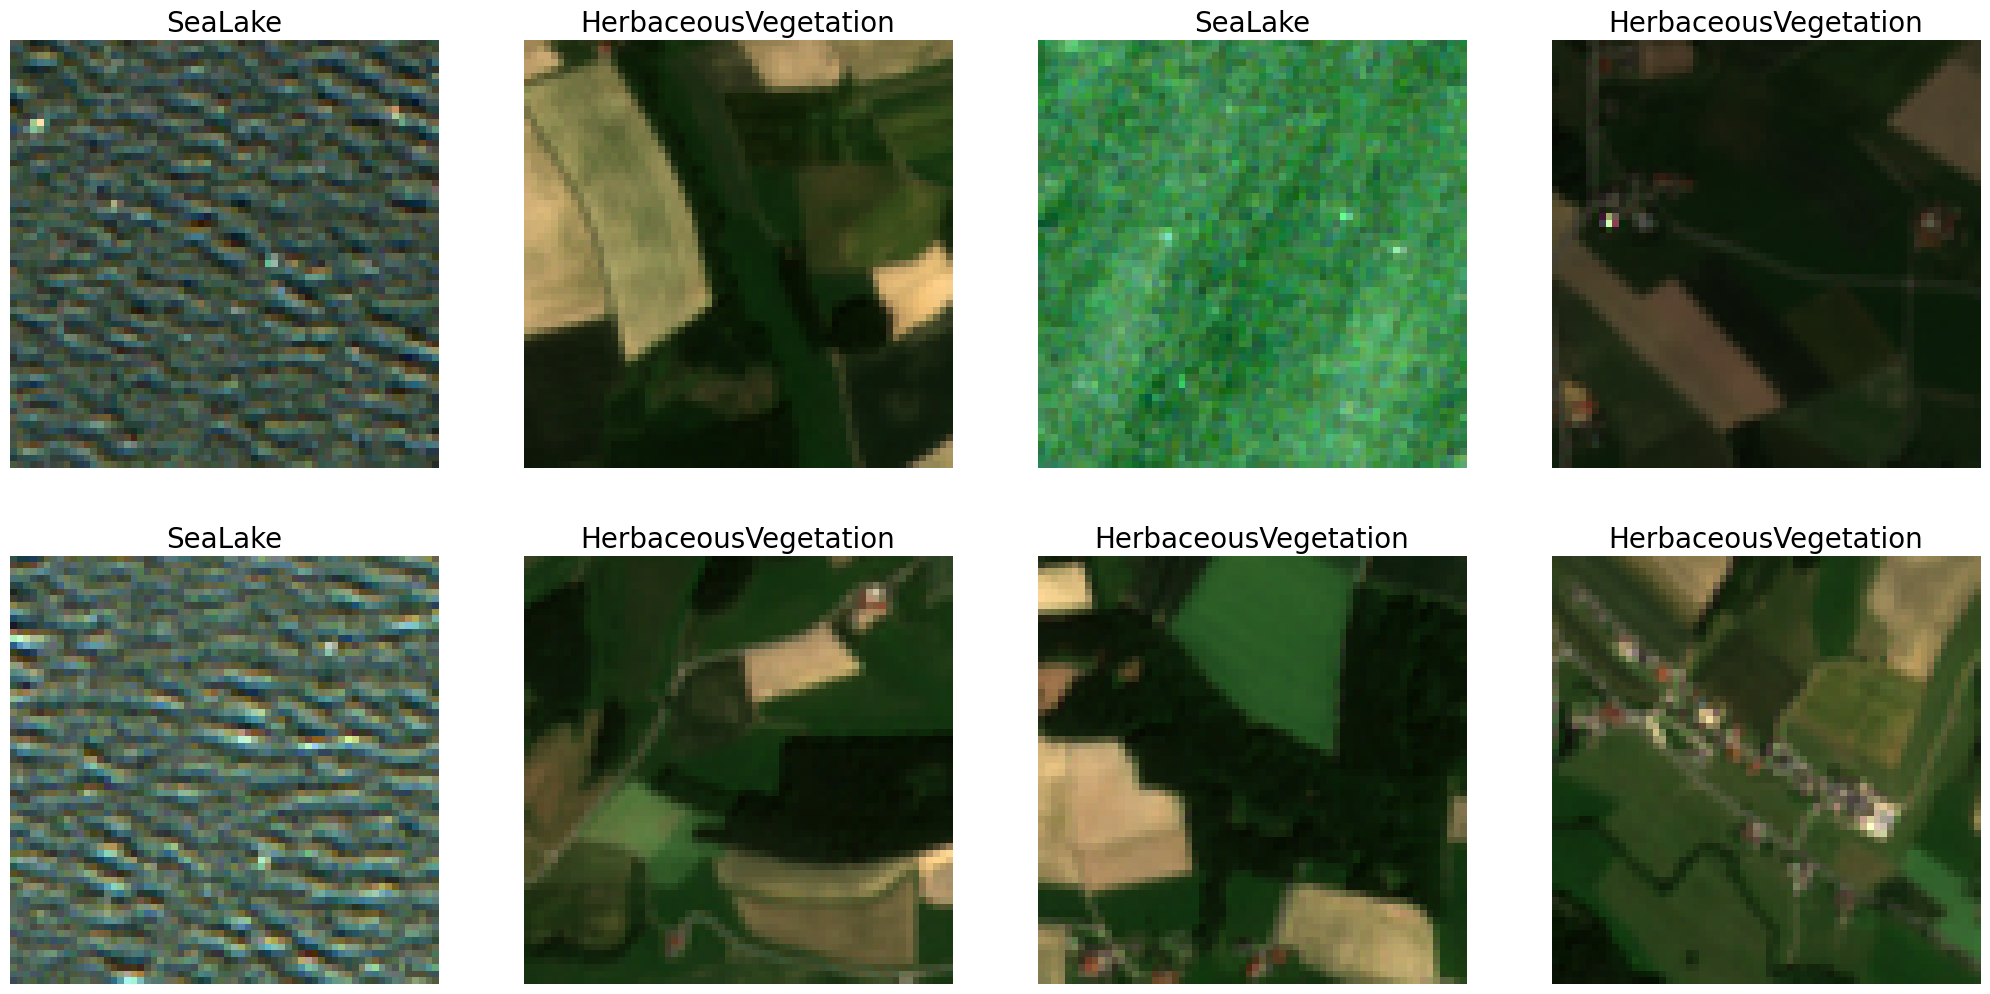

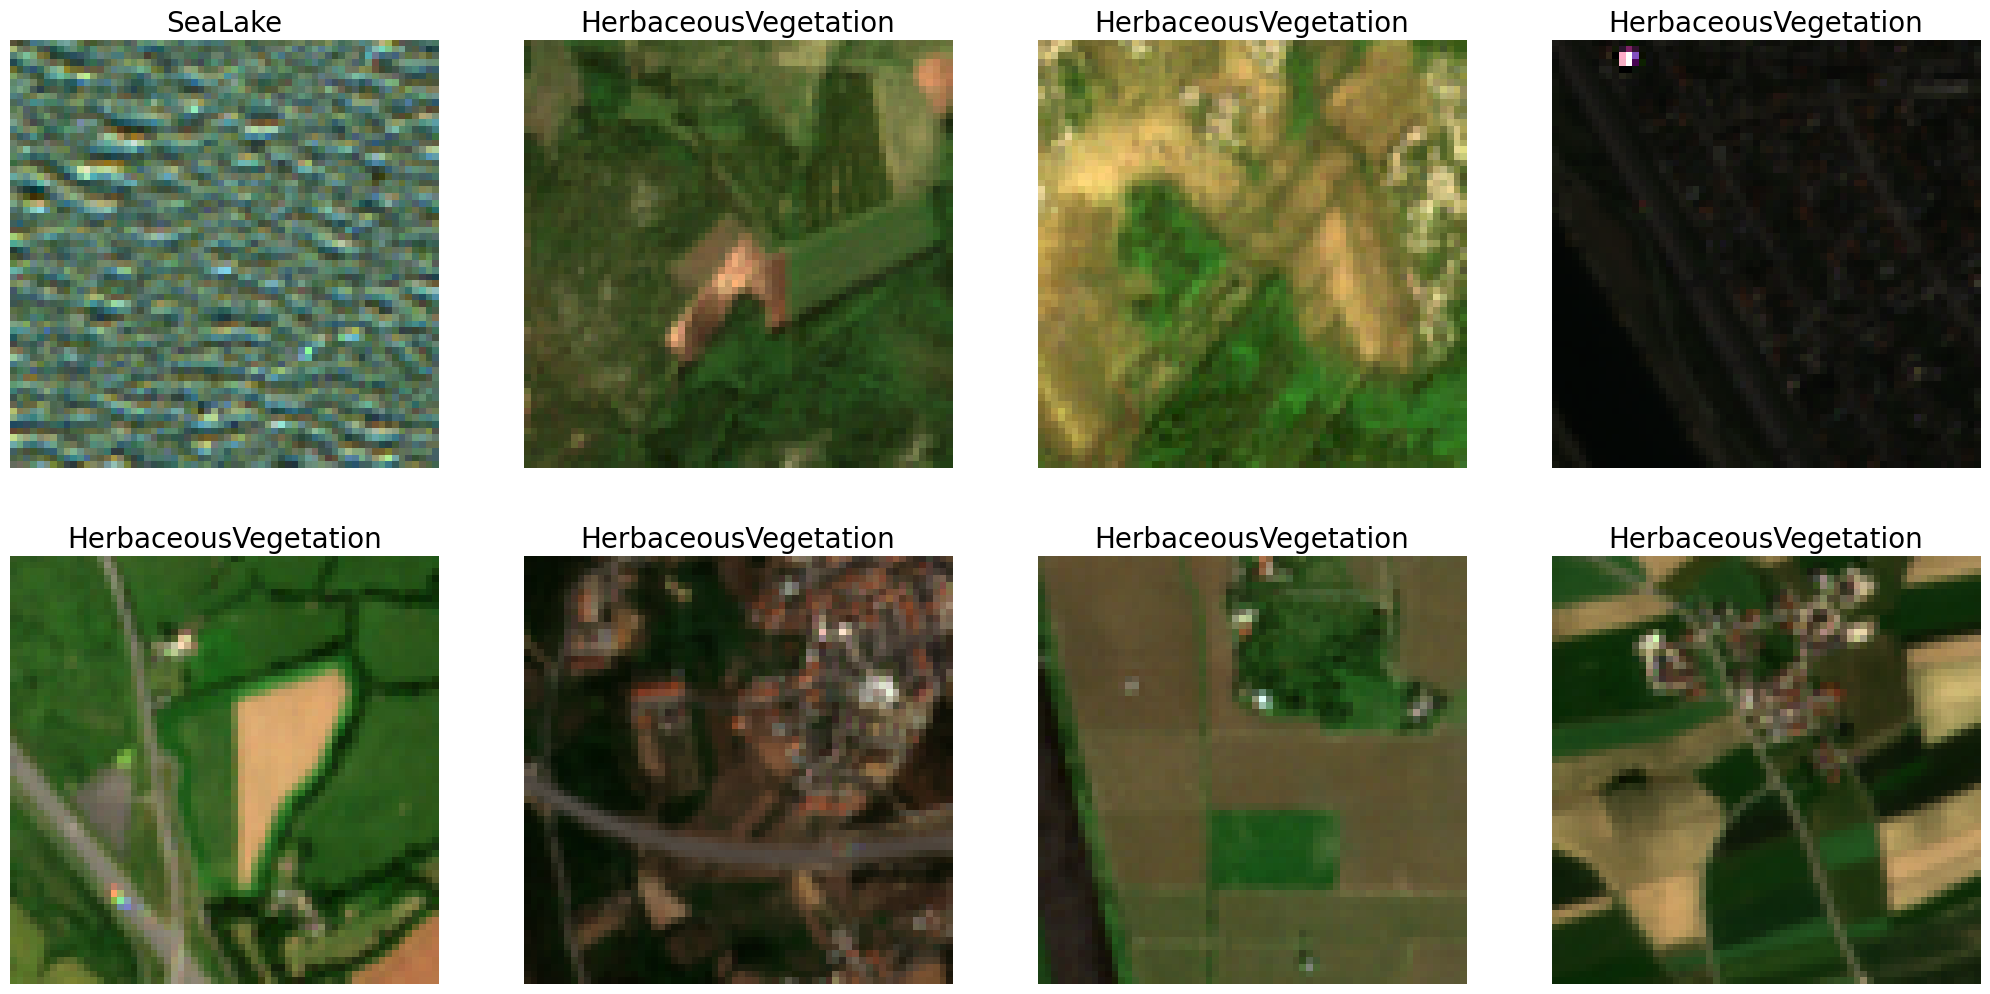

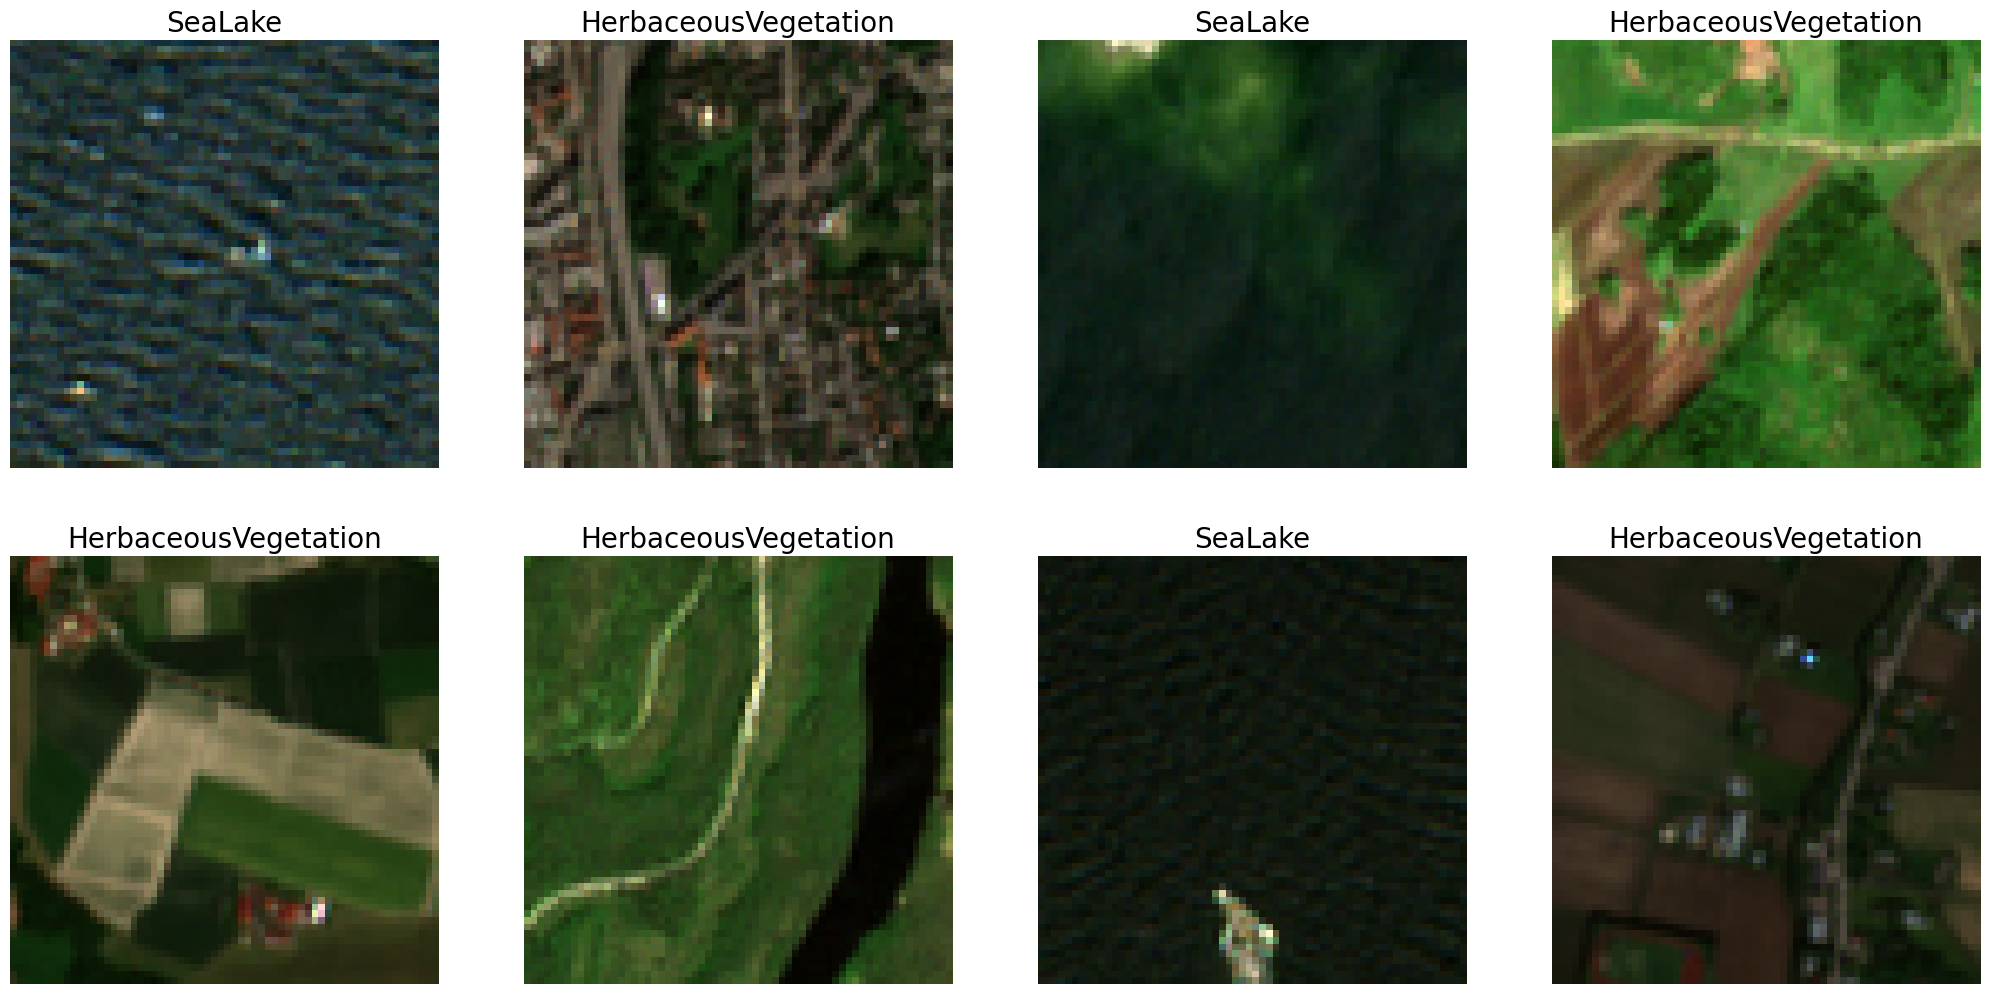

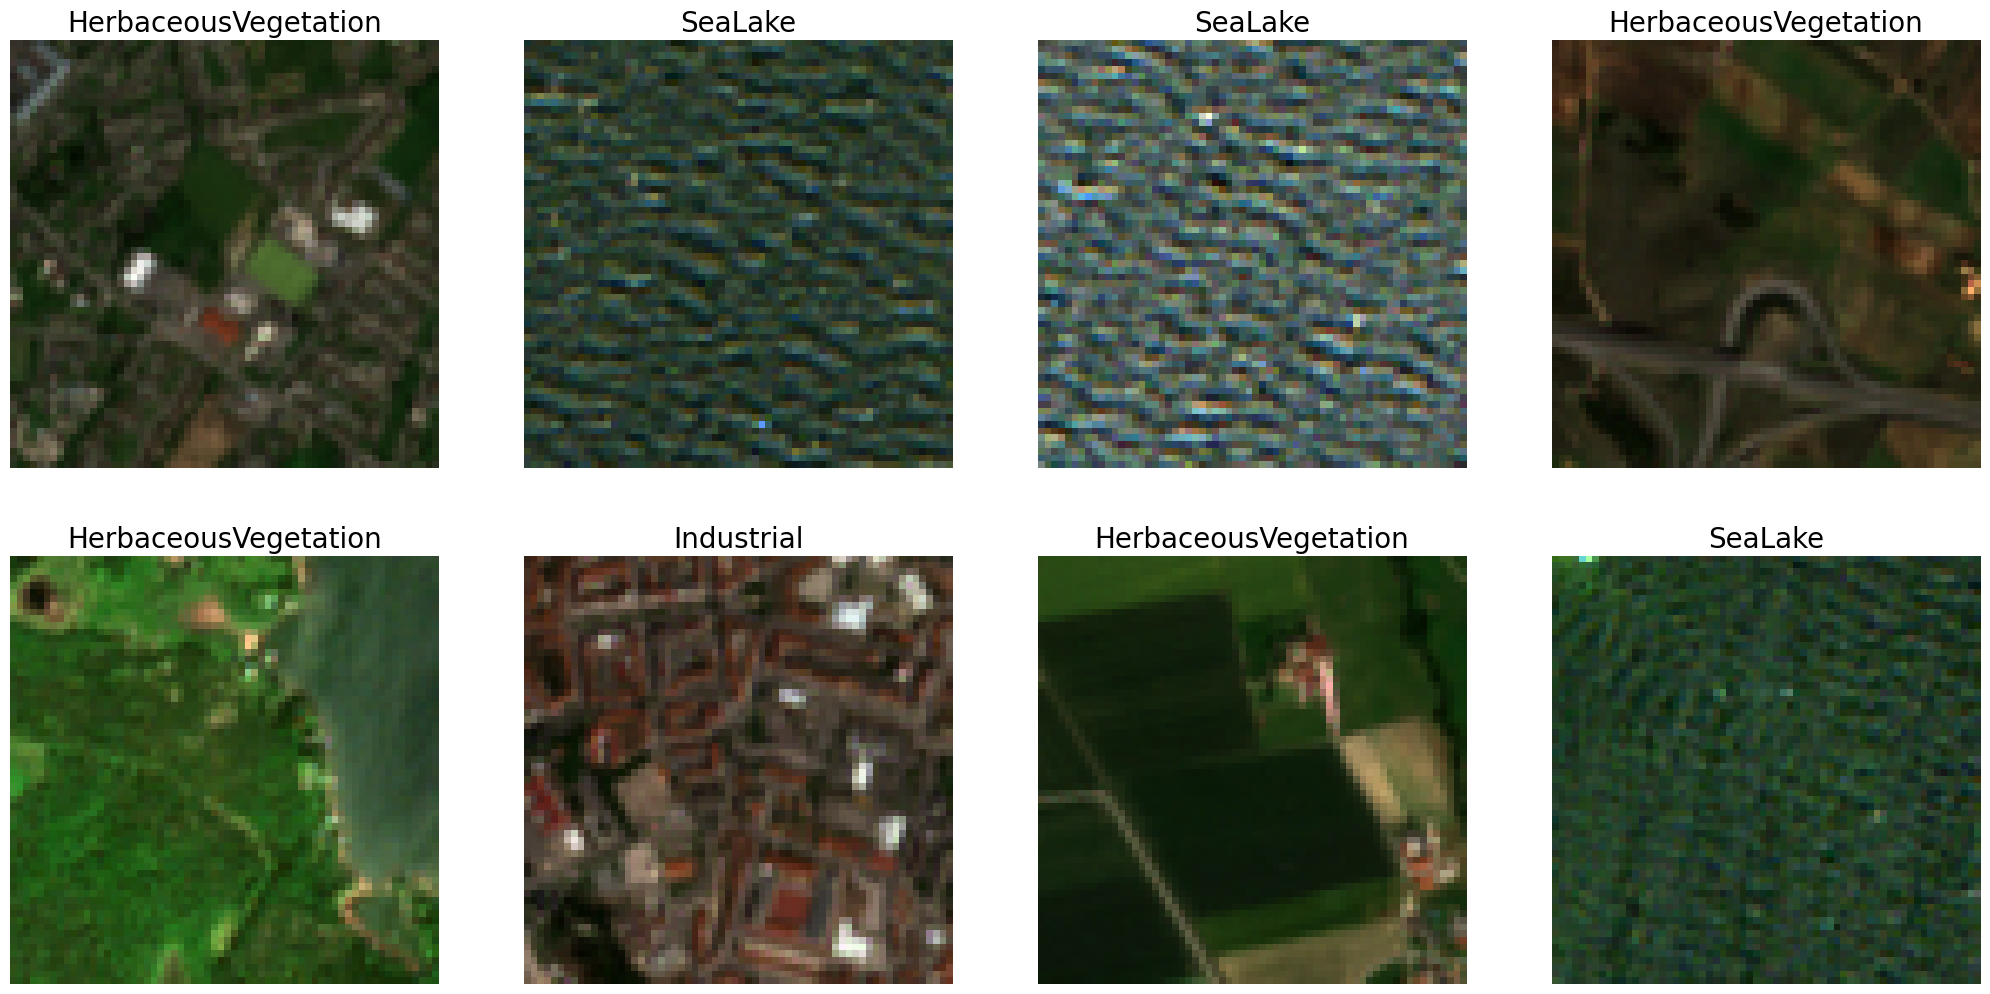

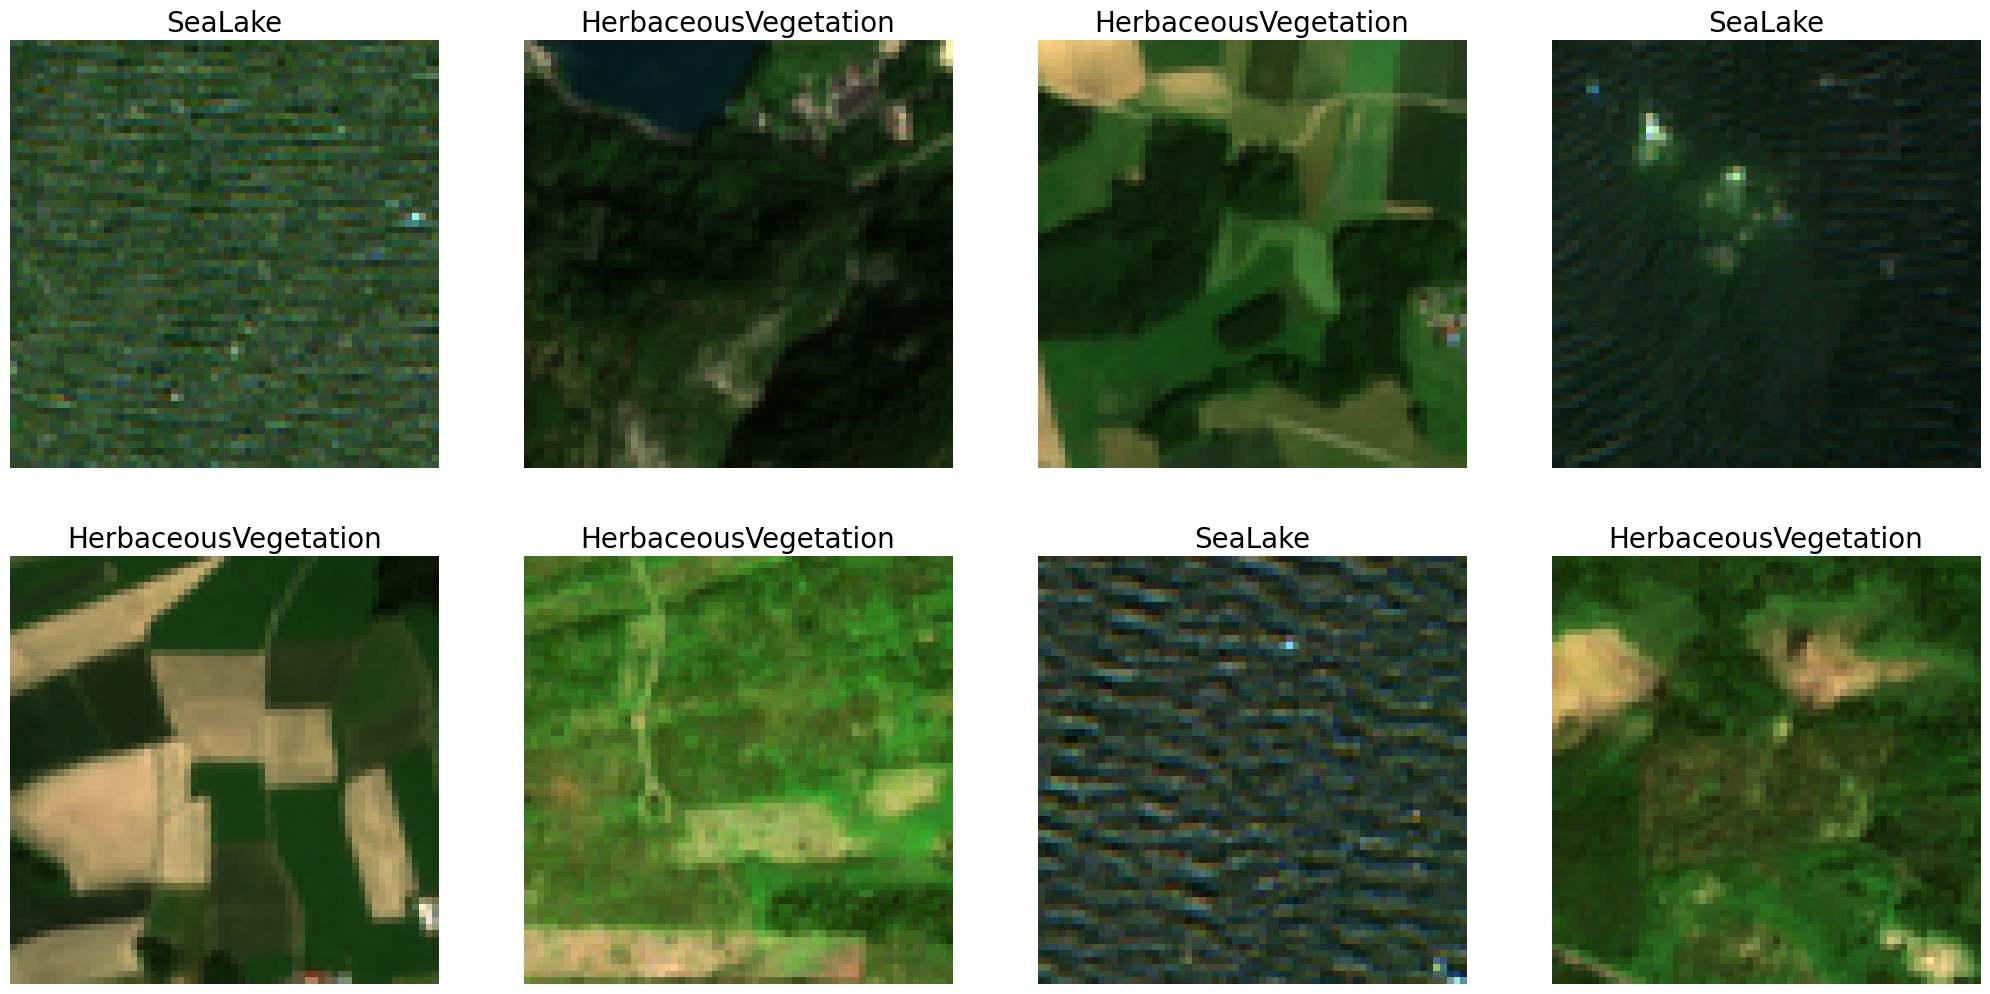

In [40]:
import random
from matplotlib import pyplot as plt

samp_batch_idx = [i for i in range(0, len(sample_ids))]
random.shuffle(samp_batch_idx)
samp_batch_idx = np.array(samp_batch_idx)
n = 10



for batch_start in range(0, n*8, 8):  # Iterate in steps of 8
    fig, axs = plt.subplots(2, 4, figsize=(20, 10))  # Create a new figure for each batch
    axs = axs.flatten()  # Flatten the grid for easy iteration

    for idx, ax in zip(samp_batch_idx[batch_start:batch_start+8], axs):
        pred = predictions[idx]
        samp_id = sample_ids[idx]
        
        im_path = f"data/test/NoLabel/test_{samp_id}.npy"
        # img = images[idx].numpy()
        
        
        img = np.load(im_path).transpose(2, 0, 1)
        img = img[[3, 2, 1]].astype(np.float32).transpose(1, 2, 0)
        
        img = img / 10000
        img = img.clip(0, 1)
        
        # img = img[[-2, -3, -4]].transpose(1, 2, 0)
        
        #raw = np.load(f"data/test/NoLabel/test_{samp_id}.npy")
        #img = raw[:, :, [3, 2, 1]]

        # Normalize the image
        rgb_min, rgb_max = img.min(), img.max()
        img = (img - rgb_min) / (rgb_max - rgb_min)

        # Plotting
        ax.imshow(img)
        ax.set_title(pred, fontsize=20)
        ax.axis('off')

    plt.tight_layout()
    plt.subplots_adjust(wspace=0.2, hspace=0.2)
    plt.show()